In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from rich.progress import track
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# construct CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 20, 5)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)
        self.fc1 = nn.Linear(3960, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn(self.conv1(x))))
        res1 = x.view(x.shape[0], -1).clone()
        x = self.pool(F.relu(self.bn(self.conv2(x))))
        res2 = x.view(x.shape[0], -1).clone()
        x = self.pool2(F.relu(self.bn(self.conv3(x))))
        res3 = x.view(x.shape[0], -1).clone()
        x = F.relu(self.bn(self.conv4(x)))
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, res2, res3), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet()
model.load_state_dict(torch.load('torch_model.pth'))



lr = 0.1
lmbda = 0.01


In [29]:
def get_optimal_input(one_hot):
    input = torch.ones((32,1,109,168))
    input.requires_grad=True
    for epoch in range(10):
        output = model(input)
        target = torch.Tensor([one_hot for _ in range(32)])
        loss = F.cross_entropy(output, target) + lmbda*torch.square(torch.norm(input))
        loss.backward()
        # if (epoch + 1) % 10 == 0: 
        #     print(f"Epoch {epoch+1}, loss = {loss.item()}, classification prob = {torch.max(F.softmax(output))}")
        #     print_input = input.detach().numpy()
        # if (epoch + 1) % 20 == 0: 
        #     plt.imshow(np.squeeze(print_input[0,0,:,:]))
        #     plt.show()
        with torch.no_grad():
            input = input - lr * input.grad
            input.requires_grad = True
    return input

### Visualize network

In [6]:
import torchviz

input = torch.ones((32,1,109,168))
output = model(input)

torchviz.make_dot(output, params=dict(model.named_parameters())).render("network_architecture",format="png")

'network_architecture.png'

### Plot all inputs
omit axes but include titles

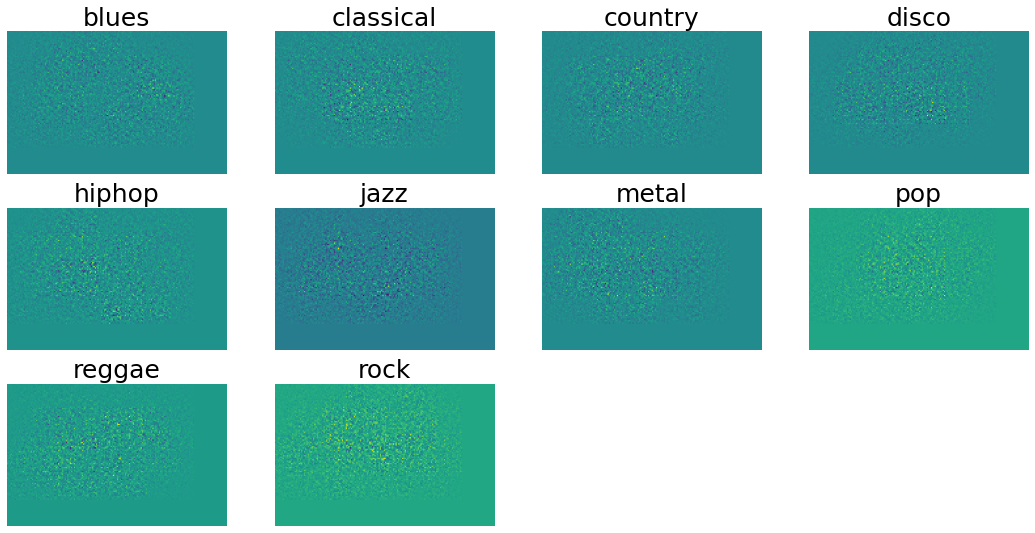

In [32]:
fig = plt.figure(facecolor='white', figsize=(10*1.5,5*1.5))

cats = np.identity(10)
categories = np.array(["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"])
for index, cat in enumerate(cats):
    img = get_optimal_input(cat)
    img2 = img.detach().numpy()
    plt.subplot(3,4,index+1)
    plt.imshow(np.squeeze(img2[0,0,:,:]))
    plt.title(categories[index], fontsize=25)
    plt.axis('off')
plt.tight_layout()
plt.savefig("max_inputs.png")
